# Forecasting GOLD price using ARIMA 

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data manipulatiing
import missingno as msgn

# modeling and training
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA


In [170]:
# load dataset
data = pd.read_csv("C:/Users/kara/Downloads/XAUUSD.csv")
data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Change(Pips),Change(%)
0,0,7/4/2023 0:00,1921.07,1930.22,1920.34,1929.65,858,0.44
1,1,7/3/2023 0:00,1917.70,1930.50,1910.11,1921.17,347,0.18
2,2,7/2/2023 0:00,1920.30,1920.30,1917.50,1917.70,-260,-0.14
3,3,6/30/2023 0:00,1908.71,1922.61,1900.57,1919.20,1049,0.55
4,4,6/29/2023 0:00,1909.47,1913.00,1893.16,1908.76,-71,-0.04


In [171]:
data.drop(['Unnamed: 0'], axis = 1, inplace=True)
data

,Date,Open,High,Low,Close,Change(Pips),Change(%)
0,7/4/2023 0:00,1921.07,1930.22,1920.34,1929.65,858,0.44
1,7/3/2023 0:00,1917.70,1930.50,1910.11,1921.17,347,0.18
2,7/2/2023 0:00,1920.30,1920.30,1917.50,1917.70,-260,-0.14
3,6/30/2023 0:00,1908.71,1922.61,1900.57,1919.20,1049,0.55
4,6/29/2023 0:00,1909.47,1913.00,1893.16,1908.76,-71,-0.04
...,...,...,...,...,...,...,...
617,7/8/2021 0:00,1803.29,1818.00,1793.90,1803.75,46,0.03
618,7/7/2021 0:00,1795.28,1809.50,1793.41,1803.22,794,0.44
619,7/6/2021 0:00,1790.85,1814.89,1789.89,1795.68,483,0.27
620,7/5/2021 0:00,1786.68,1794.00,1783.80,1791.15,447,0.25


In [172]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,622.0,1833.470354,94.417731,1627.27,1775.0800,1815.230,1913.7925,2052.78
High,622.0,1844.208939,95.163303,1640.76,1787.0850,1826.375,1924.7175,2071.32
Low,622.0,1822.538248,93.223079,1615.04,1765.4350,1808.335,1896.6700,2030.77
Close,622.0,1833.592749,94.345885,1626.89,1774.9575,1815.470,1914.7000,2051.93
Change(Pips),622.0,12.239550,1480.617616,-5559.00,-704.0000,11.500,749.5000,6612.00
Change(%),622.0,0.003617,0.804528,-3.05,-0.3800,0.005,0.4100,3.33


In [173]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Change(Pips)', 'Change(%)'], dtype='object')

In [174]:
data.drop(['Date', 'Open', 'High', 'Low','Change(Pips)', 'Change(%)'], axis = 1, inplace= True)
data

,Close
0,1929.65
1,1921.17
2,1917.70
3,1919.20
4,1908.76
...,...
617,1803.75
618,1803.22
619,1795.68
620,1791.15


<AxesSubplot: >

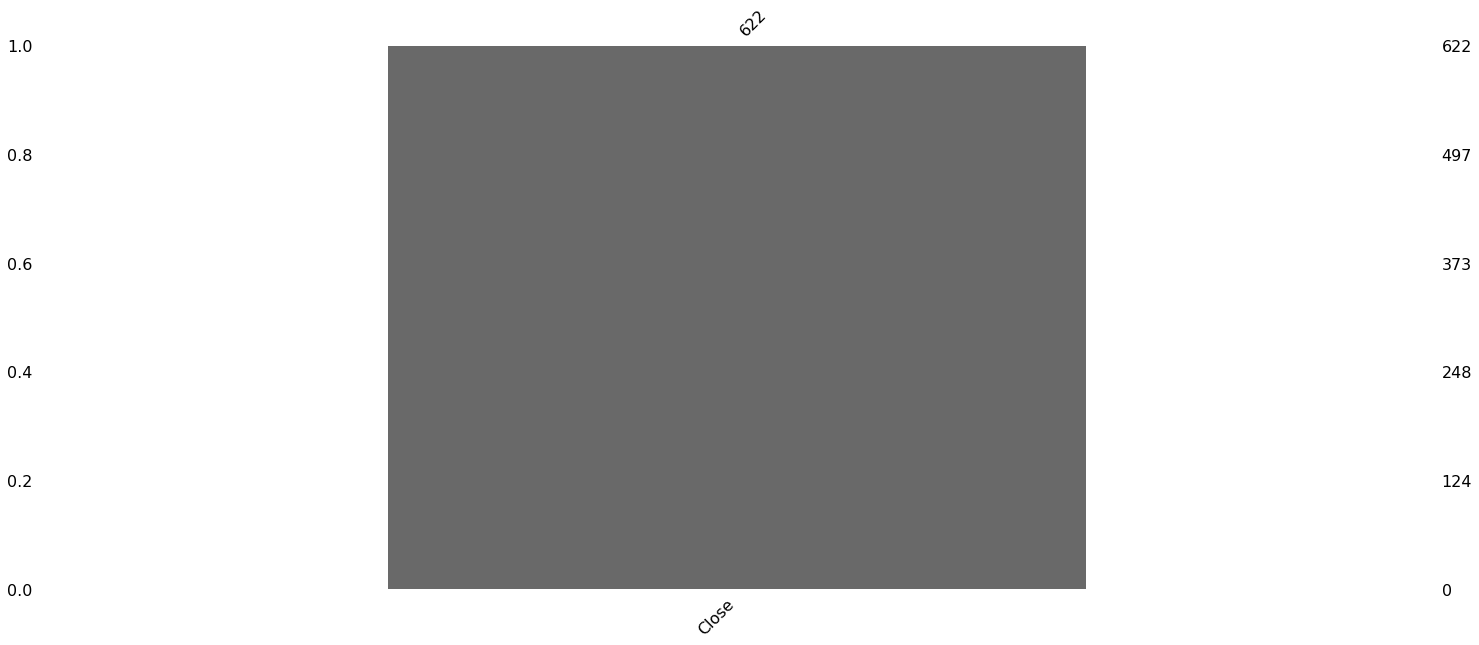

In [175]:
msgn.bar(data)

<AxesSubplot: >

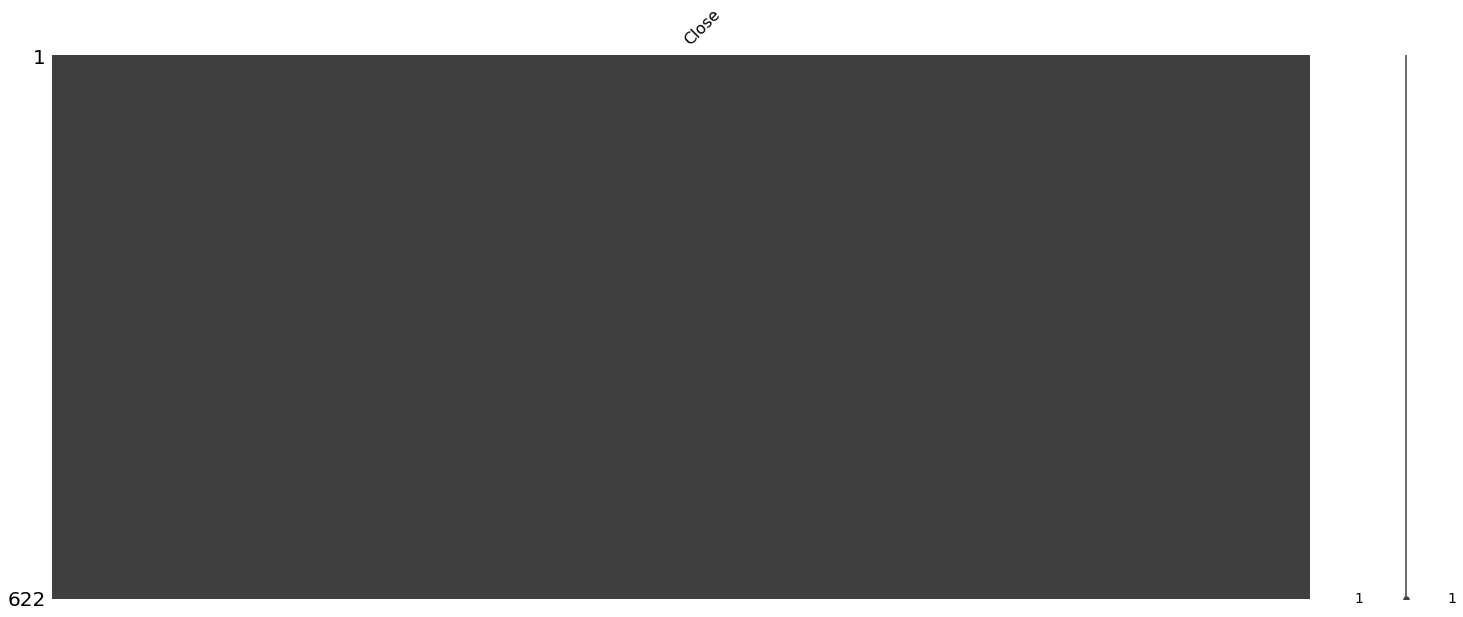

In [176]:
msgn.matrix(data)

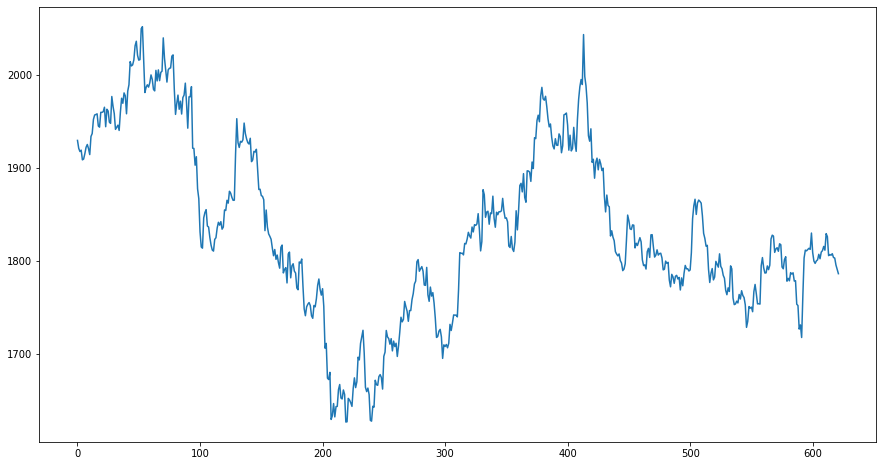

In [177]:
plt.figure(figsize=(15, 8))
plt.plot(data.Close.values)

In [178]:
# train test split
msk = (data.index < len(data)-7)
df_train = data[msk].copy()
df_test = data[~msk].copy()

# check if data is stationary or not

In [179]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

c:\Users\kara\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


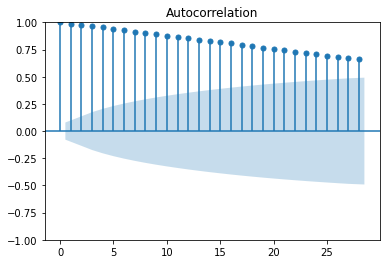

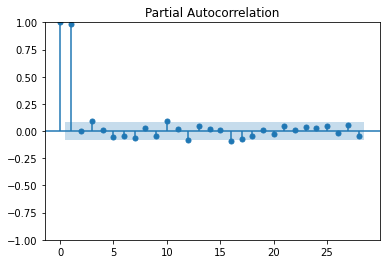

In [180]:
acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

as we can see in the plots above, ACF plots decays slowly over the time, it shows that the original data is non-sationary and it's not suitable for ARIMA model, and according to the PACF plot, after two significant lagsو PACF values are greatly reduced. it shows an AR(2) process in the data.

in addition, its a more mathy! way to determine the sationarity of data, `adfuller()` this function is a test to determine this feature, if the test value is less than 0.05, it indicates that the data is stationary. Otherwise, we have to derive from the data until the value of this test reaches the desired level

In [181]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.2595301953795735


Clearly, the data is not ideal for the ARIMA model to directly start autoregressive training. So let’s see how the differencing segment of ARIMA makes the data stationary.

c:\Users\kara\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


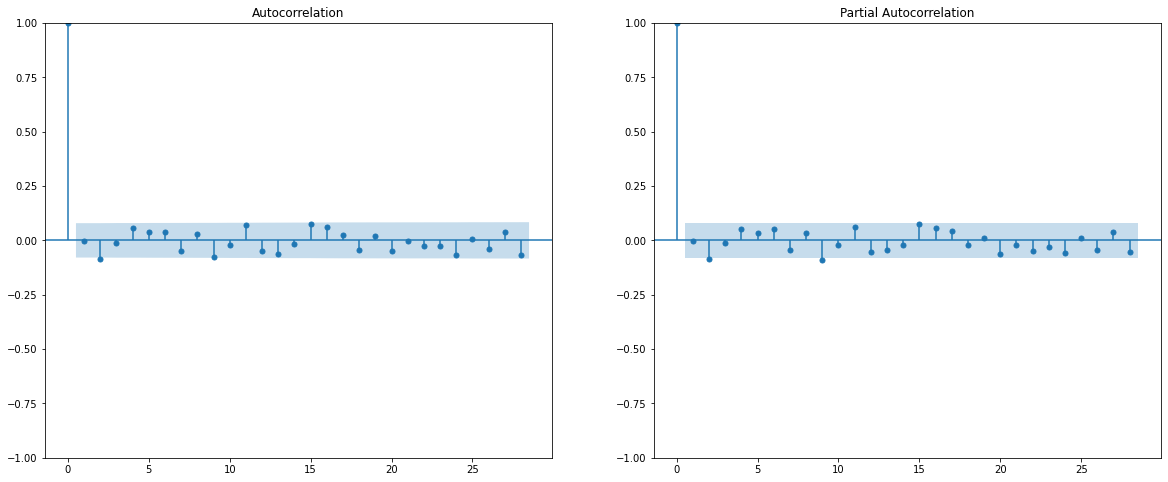

In [182]:
f = plt.figure(figsize=(20, 8))
ax1 = f.add_subplot(122)
plot_pacf(df_train.diff().dropna(), ax= ax1)

ax2 = f.add_subplot(121)
plot_acf(df_train.diff().dropna() , ax = ax2)
plt.show()

In [183]:
adf_test = adfuller(df_train.diff().dropna())
print(f'p-value: {adf_test[1]}')

p-value: 0.0


according to the result of the test and plots, the first order derivation make our data stationary.So the `d` value for our ARIMA model is 1.
also we can determine the `p` and `q` value according to the original ACF and PACF plots, as i mentioned before, the process is AR(2) and its not MA, so the `p` value is 2 and `q` is 0.

# fitting the ARIMA model

In [184]:
# creating a dictionary for benchmark
errors = {}

In [185]:
# train test split
msk = (data.index < len(data)-7)
df_train = data[msk].copy()
df_test = data[~msk].copy()

## 1- non-stepwise method

In this method, we train our ARIMA model over train data and use it `Forecast` next 7 days price.

In [186]:
arima_model = ARIMA(df_train.Close, order = (2, 1, 0))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  615
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2524.930
Date:                Wed, 12 Jul 2023   AIC                           5055.860
Time:                        03:48:00   BIC                           5069.120
Sample:                             0   HQIC                          5061.017
                                - 615                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0033      0.037     -0.089      0.929      -0.075       0.068
ar.L2         -0.0845      0.038     -2.239      0.025      -0.158      -0.011
sigma2       218.4653      9.125     23.942      0.0

cheking the diagnostic properties and density of the model.

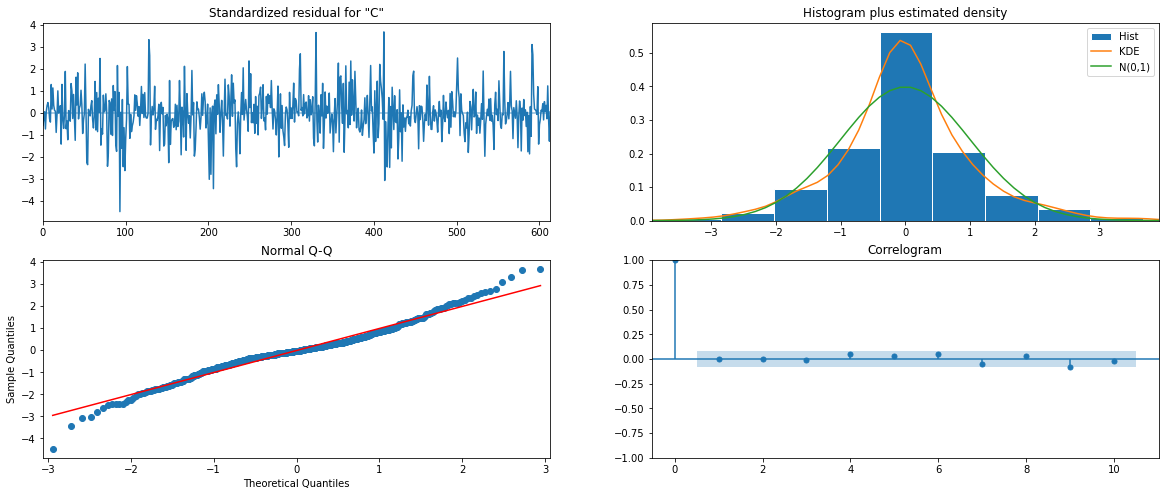

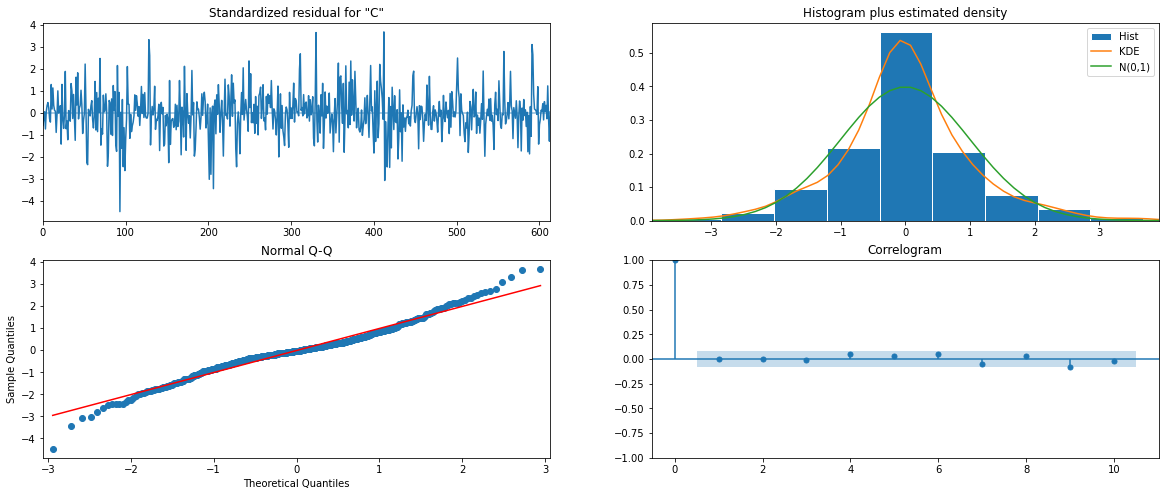

In [187]:
model.plot_diagnostics(figsize=(20, 8))

### Forecasting

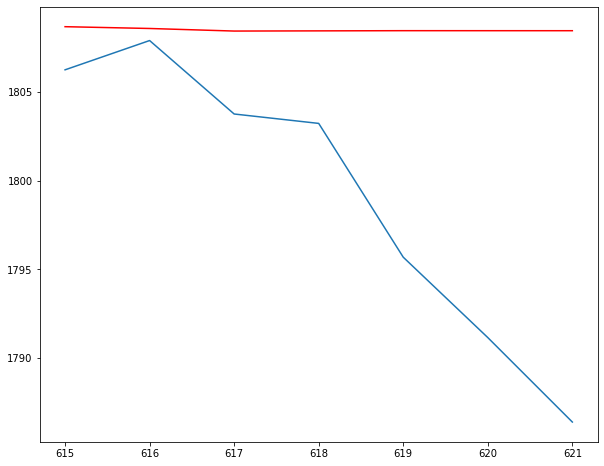

In [188]:
forecast_test = model.forecast(len(df_test))

data['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

plt.figure(figsize=(10, 8))
plt.plot(df_test.Close)
plt.plot(data['forecast_manual'], c = 'r')

In [189]:
error = mean_absolute_error(data['forecast_manual'].dropna(), df_test.Close)
errors.update({"non-stepwise": error})
print(f"non-stepwise mean_absolute_error: {error}")

non-stepwise mean_absolute_error: 9.301984642529208


## 2- fitting auto-ARIMA

The `pmdarima` package has a method `auto_arima` which considers many features to train the Arima model depending on the input data. we set `seasonal` and `stepwise` as False, we will check this properties later on this notebook.

In [190]:
import pmdarima as pm

In [191]:
auto_arima = pm.auto_arima(df_train.Close, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [192]:
print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  615
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2522.607
Date:                Wed, 12 Jul 2023   AIC                           5057.214
Time:                        03:48:05   BIC                           5083.734
Sample:                             0   HQIC                          5067.527
                                - 615                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2434      0.625     -0.390      0.697      -1.468       0.982
ar.L1          0.7673      0.096      7.968      0.000       0.579       0.956
ar.L2         -0.8736      0.086    -10.128      0.0

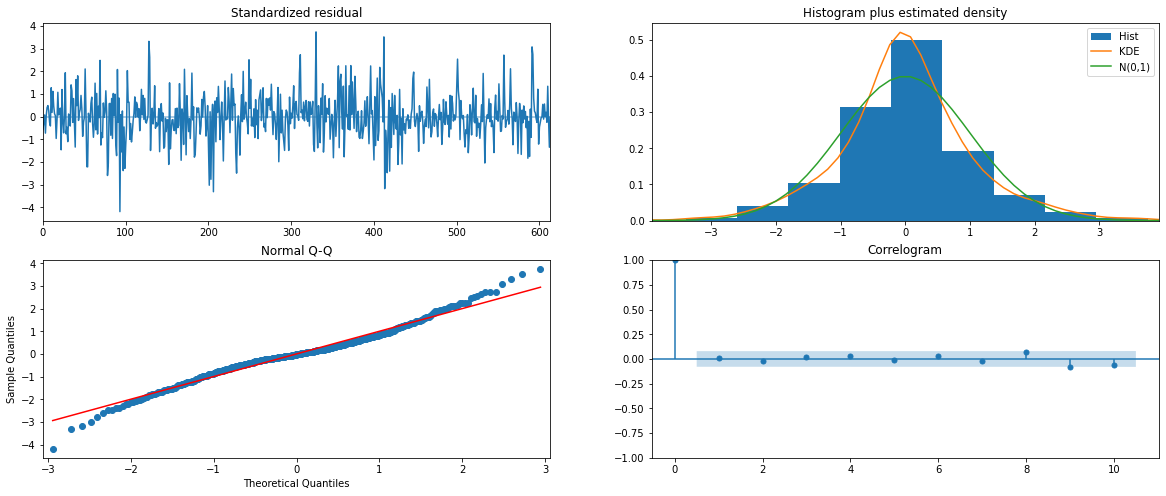

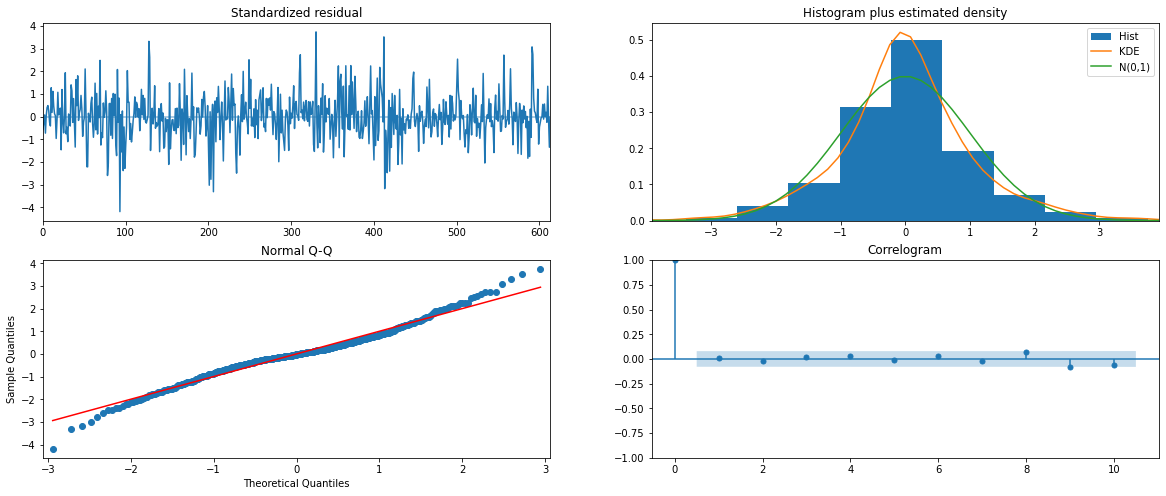

In [193]:
# check diagnostic properties
auto_arima.plot_diagnostics(figsize=(20, 8))

### Frocasting

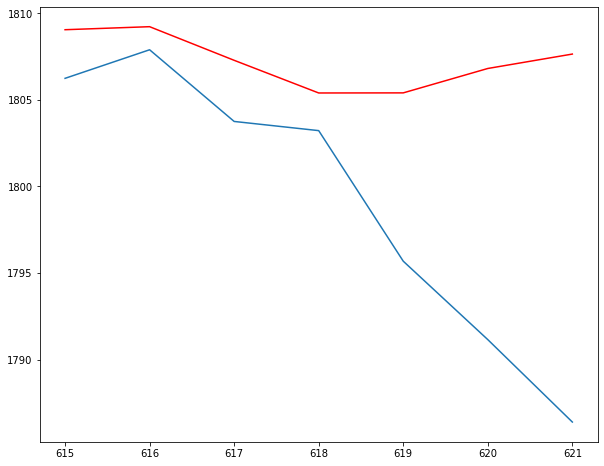

In [194]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
data['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

plt.figure(figsize=(10, 8))
plt.plot(data.Close[-7:])
plt.plot(data['forecast_auto'], c = 'r')

In [195]:
error = mean_absolute_error(data['forecast_auto'].dropna(), df_test.Close)
errors.update({"auto_ARIMA": error})
print(f"non-stepwise mean_absolute_error: {error}")

non-stepwise mean_absolute_error: 8.068157677531222


## 3 - Seasonality and SARIMA

### Do we need to test the seasonal ARIMA model?

since our dataset only has a few month of a year! there isn't any seasonal trend in the data, so we don't need to consider the seasonality of the data.

## 4- Stepwise forecasting

In this method, we train ARIMA model over the `train` data, then `Forecast` the future values step-wise, it means we only predict the price of one day after, then we record the `observation` and retrain the ARIMA model with new data, and this process takes place in the entire prediction process.

In [200]:
history = [x for x in df_train.Close] # for recording the observations
predictions = list()
for t in range(len(df_test)):
 model = ARIMA(history, order=(2,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = df_test.Close.iloc[t]
 history.append(obs)

([<matplotlib.lines.Line2D at 0x1835b405e70>],
 [<matplotlib.lines.Line2D at 0x1835c8347f0>])

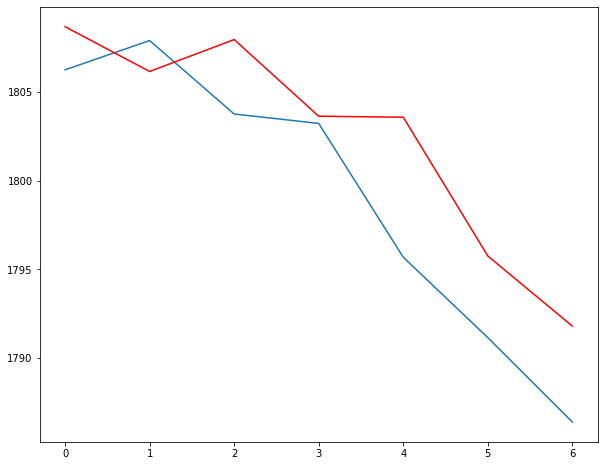

In [197]:
test = [x for x in df_test.Close]
plt.figure(figsize=(10, 8))
plt.plot(test), plt.plot(predictions, c = 'r')

In [198]:
errors.update({'stepwise forecasting' : mean_absolute_error(df_test.Close, predictions)})
print(f'mean_absolute_error of stepwise forecasting: {mean_absolute_error(df_test.Close, predictions)}')

mean_absolute_error of stepwise forecasting: 3.8097389214516886


# Benchmarks and conclusion

In [199]:
import pprint

# Prints the nicely formatted dictionary
pprint.pprint(errors)

# Sets 'pretty_dict_str' to the formatted string value
pretty_dict_str = pprint.pformat(errors)

{'auto_ARIMA': 8.068157677531222,
 'non-stepwise': 9.301984642529208,
 'stepwise forecasting': 3.8097389214516886}


Based on result, the best approach to `Forecast` the gold price with ARIMA model, is stepwise method. This method has limitations, because to predict the next day's price, it is necessary to use today's observed price and update the model again.

in general, ARIMA can be effective for forecasting in many cases, it may not be the most accurate model for forecasting gold prices for several reasons:

1 - `Nonlinearity`: Gold prices are influenced by a wide range of factors, including economic indicators, geopolitical events, investor sentiment, and market dynamics. These factors often exhibit nonlinear relationships, which can make it challenging for ARIMA, a linear model, to capture the complexities accurately.

2 - `Volatility and outliers`: Gold prices are known for their volatility and occasional large price movements driven by unexpected events or market shocks. ARIMA assumes that the data is stationary, meaning that it has a constant mean and variance over time. However, gold price data often violates this assumption due to volatility and outliers, making it difficult for ARIMA to produce accurate forecasts.

3 - `Seasonality`: ARIMA models are not inherently designed to handle seasonality patterns. Gold prices can exhibit seasonal patterns, such as higher demand during certain times of the year or recurring economic cycles. ARIMA may struggle to capture and incorporate these seasonal patterns effectively, resulting in less accurate forecasts.

4 - `Structural breaks`: Gold prices can be influenced by structural breaks, which are sudden and significant shifts in the underlying economic or market conditions. ARIMA assumes stationarity and does not automatically account for structural breaks. When such breaks occur, the historical patterns and relationships used by ARIMA may become less relevant, leading to less accurate forecasts.

Given these limitations, alternative forecasting methods that can account for nonlinearities, seasonality, volatility, and structural breaks might be more suitable for forecasting gold prices. These methods could include machine learning techniques like `neural networks`, `random forests`, or other advanced time series models specifically designed to handle complex and dynamic data patterns. Additionally, incorporating domain knowledge, `economic indicators`, and other relevant factors into the forecasting process can enhance the accuracy of gold price predictions.
